Opening raw data file ../data/pilot_data/sub-01_ses-001_raw_preprocessed_LandoitC_noEpoched.fif...
    Range : 637484 ... 880217 =   2124.947 ...  2934.057 secs
Ready.
Reading 0 ... 242733  =      0.000 ...   809.110 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 9901 samples (33.003 s)



C:\Users\s\AppData\Local\Temp\ipykernel_37492\2886967351.py:40: RuntimeWarning: This filename (../data/pilot_data/sub-01_ses-001_raw_preprocessed_LandoitC_noEpoched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(data_path, preload=True)


275 events found on stim channel Trigger
Event IDs: [  1   2   3   4   7   8   9  10  11  13  14  15  16  17  18  21  22  23
  24  25  26  27  28  30  31  32  34  37  38  39  40  41  44  45  46  47
  48  50  51  52  54  64 128]
Unique event codes before recoding: [  1   2   3   4   7   8   9  10  11  13  14  15  16  17  18  21  22  23
  24  25  26  27  28  30  31  32  34  37  38  39  40  41  44  45  46  47
  48  50  51  52  54  64 128]
Not setting metadata
60 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 60 events and 421 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should us

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


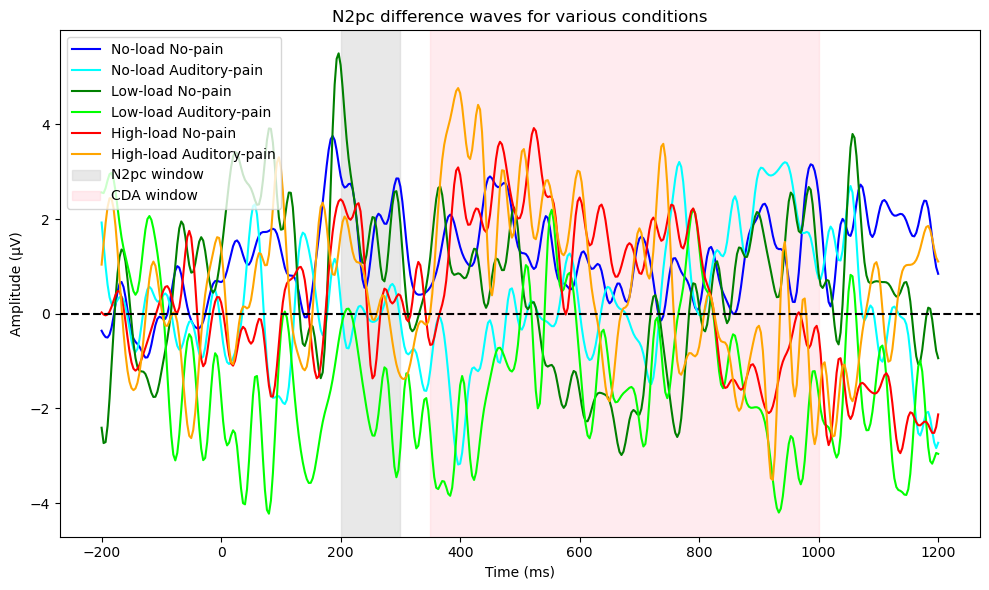

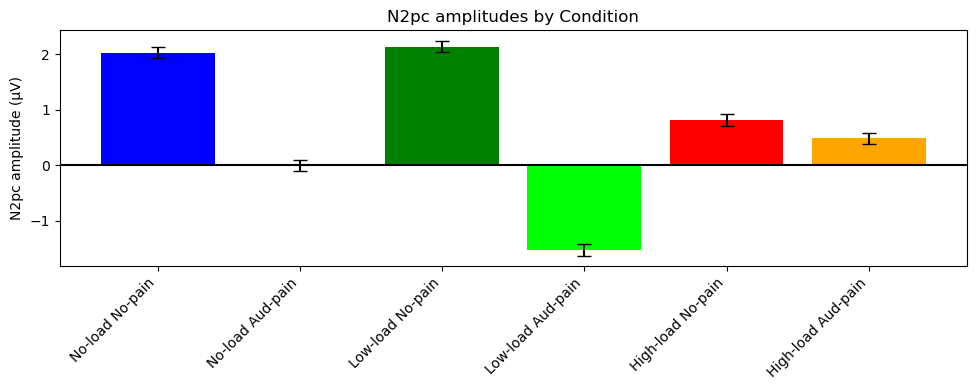

In [6]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------
# User adjustments
data_path = "../data/pilot_data/sub-01_ses-001_raw_preprocessed_LandoitC_noEpoched.fif"

# N2pc time window
N2pc_start, N2pc_end = 0.2, 0.3  # 200–300 ms
CDA_start, CDA_end = 0.35, 1.0   # optional if you want to show CDA

# Electrode sets (assuming contralateral/ipsilateral known)
left_hemi = ['P3','T5','O1']
right_hemi = ['P4','T6','O2']

# Conditions and triggers (from your specification)
no_load_no_pain_triggers = [17]
no_load_auditory_pain_triggers = [34]

low_load_no_pain_triggers = [2,4,6,8,19,21,23,25]
low_load_auditory_pain_triggers = [36,38,40,42]

high_load_no_pain_triggers = [10,12,14,16,27,29,31,33]
high_load_auditory_pain_triggers = [44,46,48,50]

# Assign event IDs
# Each condition gets its own code:
event_map = {
    'no_load_no_pain': 110,
    'no_load_auditory_pain': 120,
    'low_load_no_pain': 210,
    'low_load_auditory_pain': 220,
    'high_load_no_pain': 310,
    'high_load_auditory_pain': 320
}

# -----------------------------------------------------
# Load raw data
raw = mne.io.read_raw_fif(data_path, preload=True)

# Filter if needed
raw.filter(0.1, 30.0)

# Find events
events = mne.find_events(raw)
print("Unique event codes before recoding:", np.unique(events[:,2]))

# Recode events
for i in range(len(events)):
    trig = events[i,2]
    if trig in no_load_no_pain_triggers:
        events[i,2] = 110
    elif trig in no_load_auditory_pain_triggers:
        events[i,2] = 120
    elif trig in low_load_no_pain_triggers:
        events[i,2] = 210
    elif trig in low_load_auditory_pain_triggers:
        events[i,2] = 220
    elif trig in high_load_no_pain_triggers:
        events[i,2] = 310
    elif trig in high_load_auditory_pain_triggers:
        events[i,2] = 320

# Now define event_id from event_map keys/values:
event_id = {
    'no_load_no_pain': 110,
    'no_load_auditory_pain': 120,
    'low_load_no_pain': 210,
    'low_load_auditory_pain': 220,
    'high_load_no_pain': 310,
    'high_load_auditory_pain': 320
}

# Create epochs
tmin, tmax = -0.2, 1.2  # Adjust based on your actual timing (N2pc often measured post-stimulus)
epochs = mne.Epochs(
    raw, events, event_id=event_id,
    tmin=tmin, tmax=tmax,
    baseline=(None,0),
    preload=True
)

# Get Evokeds for each condition
evoked_no_load_no_pain = epochs['no_load_no_pain'].average()
evoked_no_load_aud_pain = epochs['no_load_auditory_pain'].average()

evoked_low_load_no_pain = epochs['low_load_no_pain'].average()
evoked_low_load_aud_pain = epochs['low_load_auditory_pain'].average()

evoked_high_load_no_pain = epochs['high_load_no_pain'].average()
evoked_high_load_aud_pain = epochs['high_load_auditory_pain'].average()

# Compute difference waves for N2pc:
# If conditions are already balanced or known side, we can do as previously:
# Contralateral = right hemisphere, Ipsilateral = left hemisphere (example)
def compute_diff(evoked):
    contra = evoked.copy().pick_channels(right_hemi).data.mean(axis=0)
    ipsi = evoked.copy().pick_channels(left_hemi).data.mean(axis=0)
    return contra - ipsi

diff_no_load_no_pain = compute_diff(evoked_no_load_no_pain)
diff_no_load_aud_pain = compute_diff(evoked_no_load_aud_pain)
diff_low_load_no_pain = compute_diff(evoked_low_load_no_pain)
diff_low_load_aud_pain = compute_diff(evoked_low_load_aud_pain)
diff_high_load_no_pain = compute_diff(evoked_high_load_no_pain)
diff_high_load_aud_pain = compute_diff(evoked_high_load_aud_pain)

times = evoked_no_load_no_pain.times

def mean_amplitude(data, times, start, end):
    mask = (times >= start) & (times <= end)
    return data[mask].mean()

# Compute N2pc amplitudes
N2pc_no_load_no_pain = mean_amplitude(diff_no_load_no_pain, times, N2pc_start, N2pc_end)
N2pc_no_load_aud_pain = mean_amplitude(diff_no_load_aud_pain, times, N2pc_start, N2pc_end)

N2pc_low_load_no_pain = mean_amplitude(diff_low_load_no_pain, times, N2pc_start, N2pc_end)
N2pc_low_load_aud_pain = mean_amplitude(diff_low_load_aud_pain, times, N2pc_start, N2pc_end)

N2pc_high_load_no_pain = mean_amplitude(diff_high_load_no_pain, times, N2pc_start, N2pc_end)
N2pc_high_load_aud_pain = mean_amplitude(diff_high_load_aud_pain, times, N2pc_start, N2pc_end)

# Dummy SEM values if you have multiple participants:
SEM = 0.1

# Plot difference waves
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(times*1000, diff_no_load_no_pain*1e6, label='No-load No-pain', color='blue')
ax.plot(times*1000, diff_no_load_aud_pain*1e6, label='No-load Auditory-pain', color='cyan')
ax.plot(times*1000, diff_low_load_no_pain*1e6, label='Low-load No-pain', color='green')
ax.plot(times*1000, diff_low_load_aud_pain*1e6, label='Low-load Auditory-pain', color='lime')
ax.plot(times*1000, diff_high_load_no_pain*1e6, label='High-load No-pain', color='red')
ax.plot(times*1000, diff_high_load_aud_pain*1e6, label='High-load Auditory-pain', color='orange')

# Shade N2pc and CDA intervals
ax.axvspan(N2pc_start*1000, N2pc_end*1000, color='lightgray', alpha=0.5, label='N2pc window')
ax.axvspan(CDA_start*1000, CDA_end*1000, color='pink', alpha=0.3, label='CDA window')

ax.axhline(0, color='k', linestyle='--')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (µV)')
ax.set_title('N2pc difference waves for various conditions')
ax.legend()
plt.tight_layout()
plt.show()

# Create bar plot for N2pc amplitudes
conditions = [
    'No-load No-pain', 'No-load Aud-pain',
    'Low-load No-pain', 'Low-load Aud-pain',
    'High-load No-pain', 'High-load Aud-pain'
]
N2pc_means = [
    N2pc_no_load_no_pain*1e6, N2pc_no_load_aud_pain*1e6,
    N2pc_low_load_no_pain*1e6, N2pc_low_load_aud_pain*1e6,
    N2pc_high_load_no_pain*1e6, N2pc_high_load_aud_pain*1e6
]
N2pc_sems = [SEM]*6

x = np.arange(len(conditions))
fig, ax = plt.subplots(figsize=(10,4))
bars = ax.bar(x, N2pc_means, yerr=N2pc_sems, capsize=5,
              color=['blue','cyan','green','lime','red','orange'])

ax.set_xticks(x)
ax.set_xticklabels(conditions, rotation=45, ha='right')
ax.set_ylabel('N2pc amplitude (µV)')
ax.set_title('N2pc amplitudes by Condition')
ax.axhline(0, color='k')

plt.tight_layout()
plt.show()


Opening raw data file ../data/pilot_data/sub-01_ses-001_raw_preprocessed_LandoitC_noEpoched.fif...
    Range : 637484 ... 880217 =   2124.947 ...  2934.057 secs
Ready.
Reading 0 ... 242733  =      0.000 ...   809.110 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 9901 samples (33.003 s)



C:\Users\s\AppData\Local\Temp\ipykernel_37492\1984883287.py:38: RuntimeWarning: This filename (../data/pilot_data/sub-01_ses-001_raw_preprocessed_LandoitC_noEpoched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(data_path, preload=True)


275 events found on stim channel Trigger
Event IDs: [  1   2   3   4   7   8   9  10  11  13  14  15  16  17  18  21  22  23
  24  25  26  27  28  30  31  32  34  37  38  39  40  41  44  45  46  47
  48  50  51  52  54  64 128]
Unique event codes before recoding: [  1   2   3   4   7   8   9  10  11  13  14  15  16  17  18  21  22  23
  24  25  26  27  28  30  31  32  34  37  38  39  40  41  44  45  46  47
  48  50  51  52  54  64 128]
Not setting metadata
60 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 60 events and 241 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should us

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


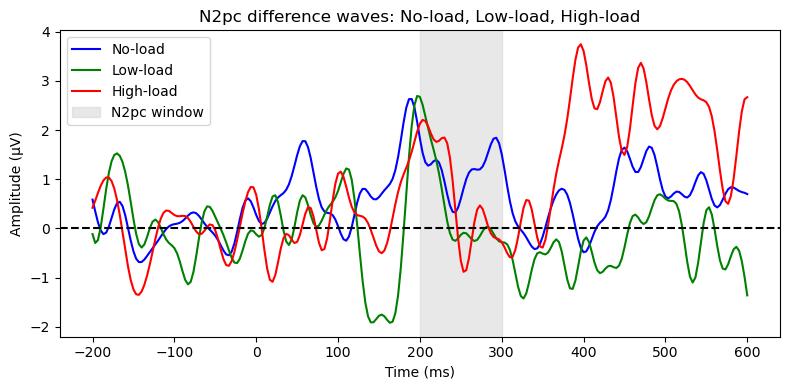

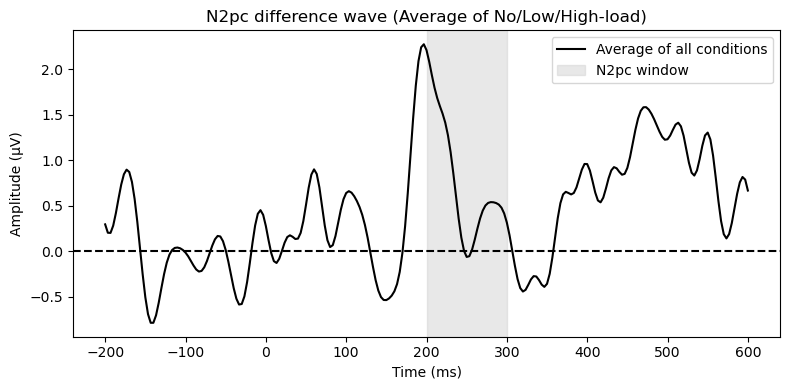

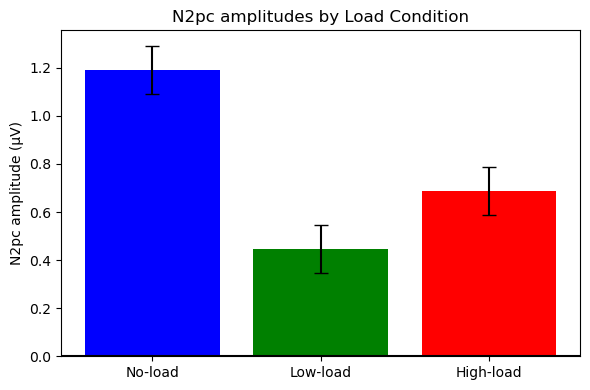

In [8]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------
# User adjustments
data_path = "../data/pilot_data/sub-01_ses-001_raw_preprocessed_LandoitC_noEpoched.fif"

# N2pc time window
N2pc_start, N2pc_end = 0.2, 0.3  # 200–300 ms

# Electrode sets (assuming a known lateralization approach)
left_hemi = ['P3','T5','O1']
right_hemi = ['P4','T6','O2']

# From your previous lists:
no_load_no_pain_triggers = [17]
no_load_auditory_pain_triggers = [34]
low_load_no_pain_triggers = [2,4,6,8,19,21,23,25]
low_load_auditory_pain_triggers = [36,38,40,42]
high_load_no_pain_triggers = [10,12,14,16,27,29,31,33]
high_load_auditory_pain_triggers = [44,46,48,50]

# Merge triggers:
no_load_triggers = no_load_no_pain_triggers + no_load_auditory_pain_triggers # [17,34]
low_load_triggers = low_load_no_pain_triggers + low_load_auditory_pain_triggers # [2,4,6,8,19,21,23,25,36,38,40,42]
high_load_triggers = high_load_no_pain_triggers + high_load_auditory_pain_triggers # [10,12,14,16,27,29,31,33,44,46,48,50]

# Map each load condition to a single integer code
event_id = {
    'no_load': 100,
    'low_load': 200,
    'high_load': 300
}

# -----------------------------------------------------
# Load raw data
raw = mne.io.read_raw_fif(data_path, preload=True)

# Filter if needed
raw.filter(0.1, 30.0)

# Find events
events = mne.find_events(raw)
print("Unique event codes before recoding:", np.unique(events[:,2]))

# Recode events
for i in range(len(events)):
    trig = events[i,2]
    if trig in no_load_triggers:
        events[i,2] = 100
    elif trig in low_load_triggers:
        events[i,2] = 200
    elif trig in high_load_triggers:
        events[i,2] = 300

# Create epochs
tmin, tmax = -0.2, 0.6
epochs = mne.Epochs(
    raw, events, event_id=event_id,
    tmin=tmin, tmax=tmax,
    baseline=(None,0),
    preload=True
)

# Average each condition
evoked_no = epochs['no_load'].average()
evoked_low = epochs['low_load'].average()
evoked_high = epochs['high_load'].average()

# Compute difference waves for N2pc:
def compute_diff(evoked):
    contra = evoked.copy().pick_channels(right_hemi).data.mean(axis=0)
    ipsi = evoked.copy().pick_channels(left_hemi).data.mean(axis=0)
    return contra - ipsi

diff_no = compute_diff(evoked_no)
diff_low = compute_diff(evoked_low)
diff_high = compute_diff(evoked_high)

times = evoked_no.times

def mean_amplitude(data, times, start, end):
    mask = (times >= start) & (times <= end)
    return data[mask].mean()

# Compute N2pc amplitudes
N2pc_no = mean_amplitude(diff_no, times, N2pc_start, N2pc_end)
N2pc_low = mean_amplitude(diff_low, times, N2pc_start, N2pc_end)
N2pc_high = mean_amplitude(diff_high, times, N2pc_start, N2pc_end)

# Dummy SEM values if multiple participants
N2pc_no_sem = 0.1
N2pc_low_sem = 0.1
N2pc_high_sem = 0.1

# -----------------------------------------------------
# Plot the difference waves
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(times*1000, diff_no*1e6, color='blue', label='No-load')
ax.plot(times*1000, diff_low*1e6, color='green', label='Low-load')
ax.plot(times*1000, diff_high*1e6, color='red', label='High-load')

ax.axvspan(N2pc_start*1000, N2pc_end*1000, color='lightgray', alpha=0.5, label='N2pc window')
ax.axhline(0, color='k', linestyle='--')

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (µV)')
ax.set_title('N2pc difference waves: No-load, Low-load, High-load')
ax.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# Compute average difference wave across all three conditions
diff_mean = (diff_no + diff_low + diff_high) / 3.0

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(times*1000, diff_mean*1e6, color='black', label='Average of all conditions')
ax.axvspan(N2pc_start*1000, N2pc_end*1000, color='lightgray', alpha=0.5, label='N2pc window')
ax.axhline(0, color='k', linestyle='--')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (µV)')
ax.set_title('N2pc difference wave (Average of No/Low/High-load)')
ax.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# Bar plot of N2pc amplitudes
conditions = ['No-load', 'Low-load', 'High-load']
N2pc_means = [N2pc_no*1e6, N2pc_low*1e6, N2pc_high*1e6]  # convert to µV
N2pc_sems = [N2pc_no_sem, N2pc_low_sem, N2pc_high_sem]

x = np.arange(len(conditions))
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(x, N2pc_means, yerr=N2pc_sems, capsize=5,
       color=['blue','green','red'])
ax.set_xticks(x)
ax.set_xticklabels(conditions)
ax.set_ylabel('N2pc amplitude (µV)')
ax.set_title('N2pc amplitudes by Load Condition')
ax.axhline(0, color='k')
plt.tight_layout()
plt.show()
